In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn 
import torch.nn.functional as F
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from torch.utils.data import DataLoader

In [2]:
# Dataset 
raw_data = load_boston()

data = raw_data.data
# label = raw_data.data

np.random.shuffle(data)

trainset_size = data.shape[0] * 7 // 10

X_train = data[:trainset_size,:]
X_test = data[trainset_size:,:]

In [3]:
# Preprocessing 
scaler = preprocessing.StandardScaler().fit(X_train)

X_train = torch.tensor(scaler.transform(X_train)).type(torch.float64)
X_test = torch.tensor(scaler.transform(X_test)).type(torch.float64)

In [4]:
# Models 
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.input = nn.Linear(input_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_z = nn.Linear(hidden_dim, latent_dim)
        self.std_z = nn.Linear(hidden_dim, latent_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_z = self.mu_z(out)
        std_z = self.std_z(out)
        
        return mu_z, std_z

        
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super().__init__()
        self.input = nn.Linear(latent_dim, hidden_dim)
        self.hidden = nn.Linear(hidden_dim, hidden_dim)
        self.mu_x = nn.Linear(hidden_dim, output_dim)
        self.std_x = nn.Linear(hidden_dim, output_dim)
    
    def forward(self, x):
        out = F.relu(self.input(x))
        mu_x = self.mu_x(out)
        std_x = self.std_x(out)
        
        return mu_x, std_x

In [5]:
INPUT_DIM = len(raw_data.feature_names)
HIDDEN_DIM = 5
LATENT_DIM = 5
BATCH_SIZE = 64
N_EPOCHS = 1000
lr = 1e-3
# weight_decay = 1e-2

In [6]:
enc = Encoder(INPUT_DIM, HIDDEN_DIM, LATENT_DIM).type(torch.float64)
dec = Decoder(LATENT_DIM, HIDDEN_DIM, INPUT_DIM).type(torch.float64)

In [7]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    p_z = torch.distributions.Normal(0, 1)
    z_samples = p_z.sample((X_train.shape[0], LATENT_DIM)).type(torch.float64)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x

tensor([[-0.2899,  0.1301, -0.4124,  ...,  0.5037, -0.5562, -0.0815],
        [-0.3192,  0.1348, -0.4001,  ...,  0.4879, -0.5150, -0.1214],
        [-0.3131,  0.1531, -0.4255,  ...,  0.5086, -0.5097, -0.1341],
        ...,
        [-0.3044,  0.1431, -0.4226,  ...,  0.5259, -0.5182, -0.1334],
        [-0.2973,  0.1118, -0.4411,  ...,  0.5297, -0.5620, -0.0633],
        [-0.3077,  0.1639, -0.3962,  ...,  0.5138, -0.4877, -0.1643]],
       grad_fn=<DivBackward0>)

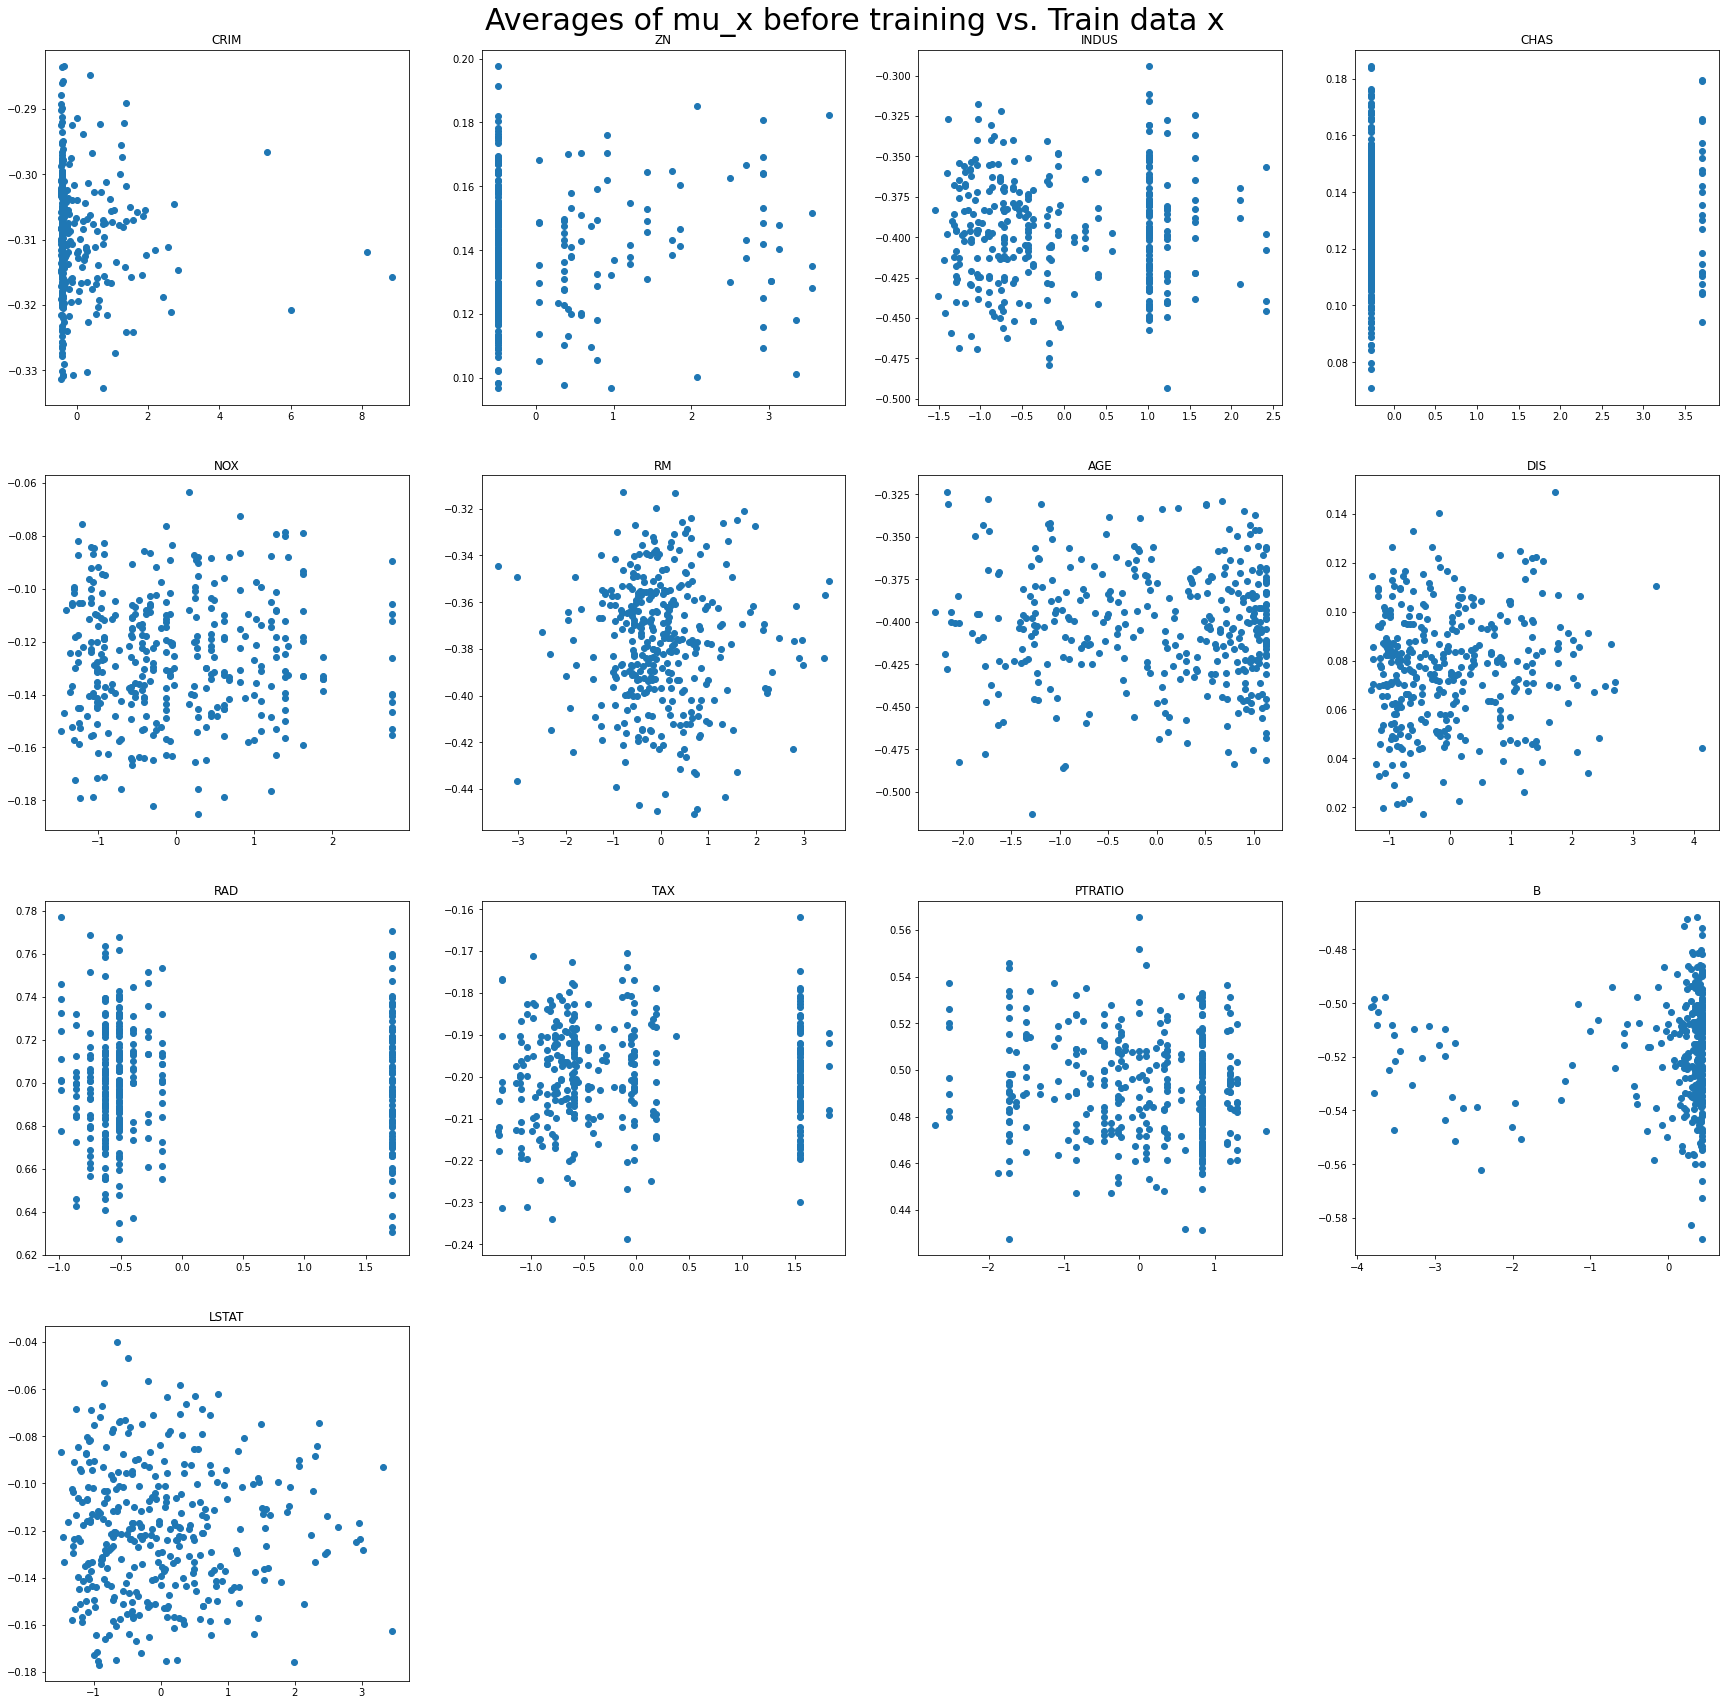

In [8]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x before training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()

In [9]:
train_iter = DataLoader(X_train, batch_size=BATCH_SIZE)

In [10]:
def loss_fn(mu_z, std_z, z_sample, mu_x, std_x, x):
    S = x.shape[0]
    
    # log posterior q(z|x)
    q_z_dist = torch.distributions.Normal(mu_z, torch.exp(std_z))
    log_q_z = q_z_dist.log_prob(z_sample)
    
    # log likelihood p(x|z)
    p_x_dist = torch.distributions.Normal(mu_x, torch.exp(std_x))
    log_p_x = p_x_dist.log_prob(x)
    
    # log prior 
    p_z_dist = torch.distributions.Normal(0, 1)
    log_p_z = p_z_dist.log_prob(z_sample)
    
    loss = (1 / S) * (
        torch.sum(log_q_z) - torch.sum(log_p_x) - torch.sum(log_p_z) 
    )
    
    return loss

In [11]:
# optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr, weight_decay=weight_decay)
optimizer = torch.optim.Adam(list(enc.parameters()) + list(dec.parameters()), lr=lr)

In [12]:
train_loss_avg = []
test_losses = []

for i in range(N_EPOCHS):
    train_loss_avg.append(0)
    num_batches = 0
    for x in train_iter: 
#         x = x.type(torch.float64)
        # Zero grad 
        optimizer.zero_grad()
        
        # Forward pass 
        mu_z, std_z = enc(x)
        eps = torch.randn_like(std_z)
        z_samples = mu_z + eps * torch.exp(std_z)
        
        mu_x, std_x = dec(z_samples)
        
        # Loss
        loss = loss_fn(mu_z, std_z, z_samples, mu_x, std_x, x)
        
        # Backward 
        loss.backward()
        
        # Update 
        optimizer.step()
        
        train_loss_avg[-1] += loss.item()
        num_batches += 1
    train_loss_avg[-1] /= num_batches
    
    
    print("Epoch [%d / %d] average loss: %f" % (i+1, N_EPOCHS, train_loss_avg[-1]))

Epoch [1 / 1000] average loss: 23.615037
Epoch [2 / 1000] average loss: 23.069167
Epoch [3 / 1000] average loss: 22.436577
Epoch [4 / 1000] average loss: 21.696161
Epoch [5 / 1000] average loss: 21.905195
Epoch [6 / 1000] average loss: 21.584379
Epoch [7 / 1000] average loss: 21.145397
Epoch [8 / 1000] average loss: 21.424534
Epoch [9 / 1000] average loss: 20.493858
Epoch [10 / 1000] average loss: 20.792240
Epoch [11 / 1000] average loss: 20.738738
Epoch [12 / 1000] average loss: 20.710969
Epoch [13 / 1000] average loss: 20.470307
Epoch [14 / 1000] average loss: 20.307440
Epoch [15 / 1000] average loss: 20.175697
Epoch [16 / 1000] average loss: 20.052072
Epoch [17 / 1000] average loss: 20.046835
Epoch [18 / 1000] average loss: 20.158720
Epoch [19 / 1000] average loss: 19.895824
Epoch [20 / 1000] average loss: 20.145829
Epoch [21 / 1000] average loss: 19.776892
Epoch [22 / 1000] average loss: 19.787451
Epoch [23 / 1000] average loss: 19.726844
Epoch [24 / 1000] average loss: 19.739478
E

Epoch [200 / 1000] average loss: 9.796725
Epoch [201 / 1000] average loss: 9.683411
Epoch [202 / 1000] average loss: 9.696044
Epoch [203 / 1000] average loss: 9.845791
Epoch [204 / 1000] average loss: 9.837457
Epoch [205 / 1000] average loss: 9.807610
Epoch [206 / 1000] average loss: 9.890222
Epoch [207 / 1000] average loss: 9.787271
Epoch [208 / 1000] average loss: 9.782607
Epoch [209 / 1000] average loss: 10.130271
Epoch [210 / 1000] average loss: 10.363306
Epoch [211 / 1000] average loss: 9.706921
Epoch [212 / 1000] average loss: 9.597815
Epoch [213 / 1000] average loss: 9.670768
Epoch [214 / 1000] average loss: 9.441079
Epoch [215 / 1000] average loss: 9.327410
Epoch [216 / 1000] average loss: 9.417474
Epoch [217 / 1000] average loss: 9.706525
Epoch [218 / 1000] average loss: 9.238647
Epoch [219 / 1000] average loss: 9.297265
Epoch [220 / 1000] average loss: 9.176199
Epoch [221 / 1000] average loss: 9.167178
Epoch [222 / 1000] average loss: 9.217021
Epoch [223 / 1000] average loss:

Epoch [401 / 1000] average loss: 5.980670
Epoch [402 / 1000] average loss: 5.901212
Epoch [403 / 1000] average loss: 5.685301
Epoch [404 / 1000] average loss: 5.718562
Epoch [405 / 1000] average loss: 5.492762
Epoch [406 / 1000] average loss: 5.515551
Epoch [407 / 1000] average loss: 5.612263
Epoch [408 / 1000] average loss: 5.754645
Epoch [409 / 1000] average loss: 5.707691
Epoch [410 / 1000] average loss: 5.894106
Epoch [411 / 1000] average loss: 5.791250
Epoch [412 / 1000] average loss: 5.603261
Epoch [413 / 1000] average loss: 5.710419
Epoch [414 / 1000] average loss: 5.670669
Epoch [415 / 1000] average loss: 5.618822
Epoch [416 / 1000] average loss: 5.559534
Epoch [417 / 1000] average loss: 5.288153
Epoch [418 / 1000] average loss: 5.411086
Epoch [419 / 1000] average loss: 5.345384
Epoch [420 / 1000] average loss: 4.975864
Epoch [421 / 1000] average loss: 5.073421
Epoch [422 / 1000] average loss: 5.154226
Epoch [423 / 1000] average loss: 6.324524
Epoch [424 / 1000] average loss: 6

Epoch [614 / 1000] average loss: 5.784883
Epoch [615 / 1000] average loss: 5.534896
Epoch [616 / 1000] average loss: 5.324087
Epoch [617 / 1000] average loss: 5.133947
Epoch [618 / 1000] average loss: 4.936665
Epoch [619 / 1000] average loss: 4.655334
Epoch [620 / 1000] average loss: 4.575046
Epoch [621 / 1000] average loss: 5.033709
Epoch [622 / 1000] average loss: 4.945961
Epoch [623 / 1000] average loss: 5.023134
Epoch [624 / 1000] average loss: 4.551932
Epoch [625 / 1000] average loss: 4.393576
Epoch [626 / 1000] average loss: 4.373199
Epoch [627 / 1000] average loss: 4.078935
Epoch [628 / 1000] average loss: 4.294135
Epoch [629 / 1000] average loss: 4.045618
Epoch [630 / 1000] average loss: 4.010772
Epoch [631 / 1000] average loss: 4.054435
Epoch [632 / 1000] average loss: 3.978029
Epoch [633 / 1000] average loss: 3.892293
Epoch [634 / 1000] average loss: 3.864689
Epoch [635 / 1000] average loss: 4.329527
Epoch [636 / 1000] average loss: 4.473566
Epoch [637 / 1000] average loss: 4

Epoch [815 / 1000] average loss: 3.348145
Epoch [816 / 1000] average loss: 3.082315
Epoch [817 / 1000] average loss: 3.030490
Epoch [818 / 1000] average loss: 2.784513
Epoch [819 / 1000] average loss: 2.761564
Epoch [820 / 1000] average loss: 2.904101
Epoch [821 / 1000] average loss: 2.851305
Epoch [822 / 1000] average loss: 3.157852
Epoch [823 / 1000] average loss: 2.880302
Epoch [824 / 1000] average loss: 3.004549
Epoch [825 / 1000] average loss: 3.129160
Epoch [826 / 1000] average loss: 3.304494
Epoch [827 / 1000] average loss: 3.057991
Epoch [828 / 1000] average loss: 2.832061
Epoch [829 / 1000] average loss: 2.823059
Epoch [830 / 1000] average loss: 2.951926
Epoch [831 / 1000] average loss: 2.929870
Epoch [832 / 1000] average loss: 3.020973
Epoch [833 / 1000] average loss: 3.232677
Epoch [834 / 1000] average loss: 3.550886
Epoch [835 / 1000] average loss: 3.834116
Epoch [836 / 1000] average loss: 4.625958
Epoch [837 / 1000] average loss: 5.104559
Epoch [838 / 1000] average loss: 4

In [13]:
avg_mu_x = torch.zeros(X_train.shape)

for i in range(100):
    p_z = torch.distributions.Normal(0, 1)
    z_samples = p_z.sample((X_train.shape[0], LATENT_DIM)).type(torch.float64)
    mu_x, std_x = dec(z_samples)
    avg_mu_x += mu_x

avg_mu_x /= 100
avg_mu_x

tensor([[-0.2047, -0.4799,  0.0314,  ...,  0.2188,  0.0509,  0.0183],
        [-0.2043, -0.4802,  0.0660,  ...,  0.2330,  0.0548,  0.1032],
        [-0.1839, -0.4797,  0.0108,  ...,  0.2043,  0.0370,  0.0268],
        ...,
        [-0.1648, -0.4805,  0.1086,  ...,  0.2616,  0.0124,  0.1373],
        [-0.1568, -0.4804,  0.1209,  ...,  0.2878, -0.0030,  0.0999],
        [-0.2151, -0.4797,  0.0176,  ...,  0.2127,  0.0627,  0.0096]],
       grad_fn=<DivBackward0>)

## Evaluation

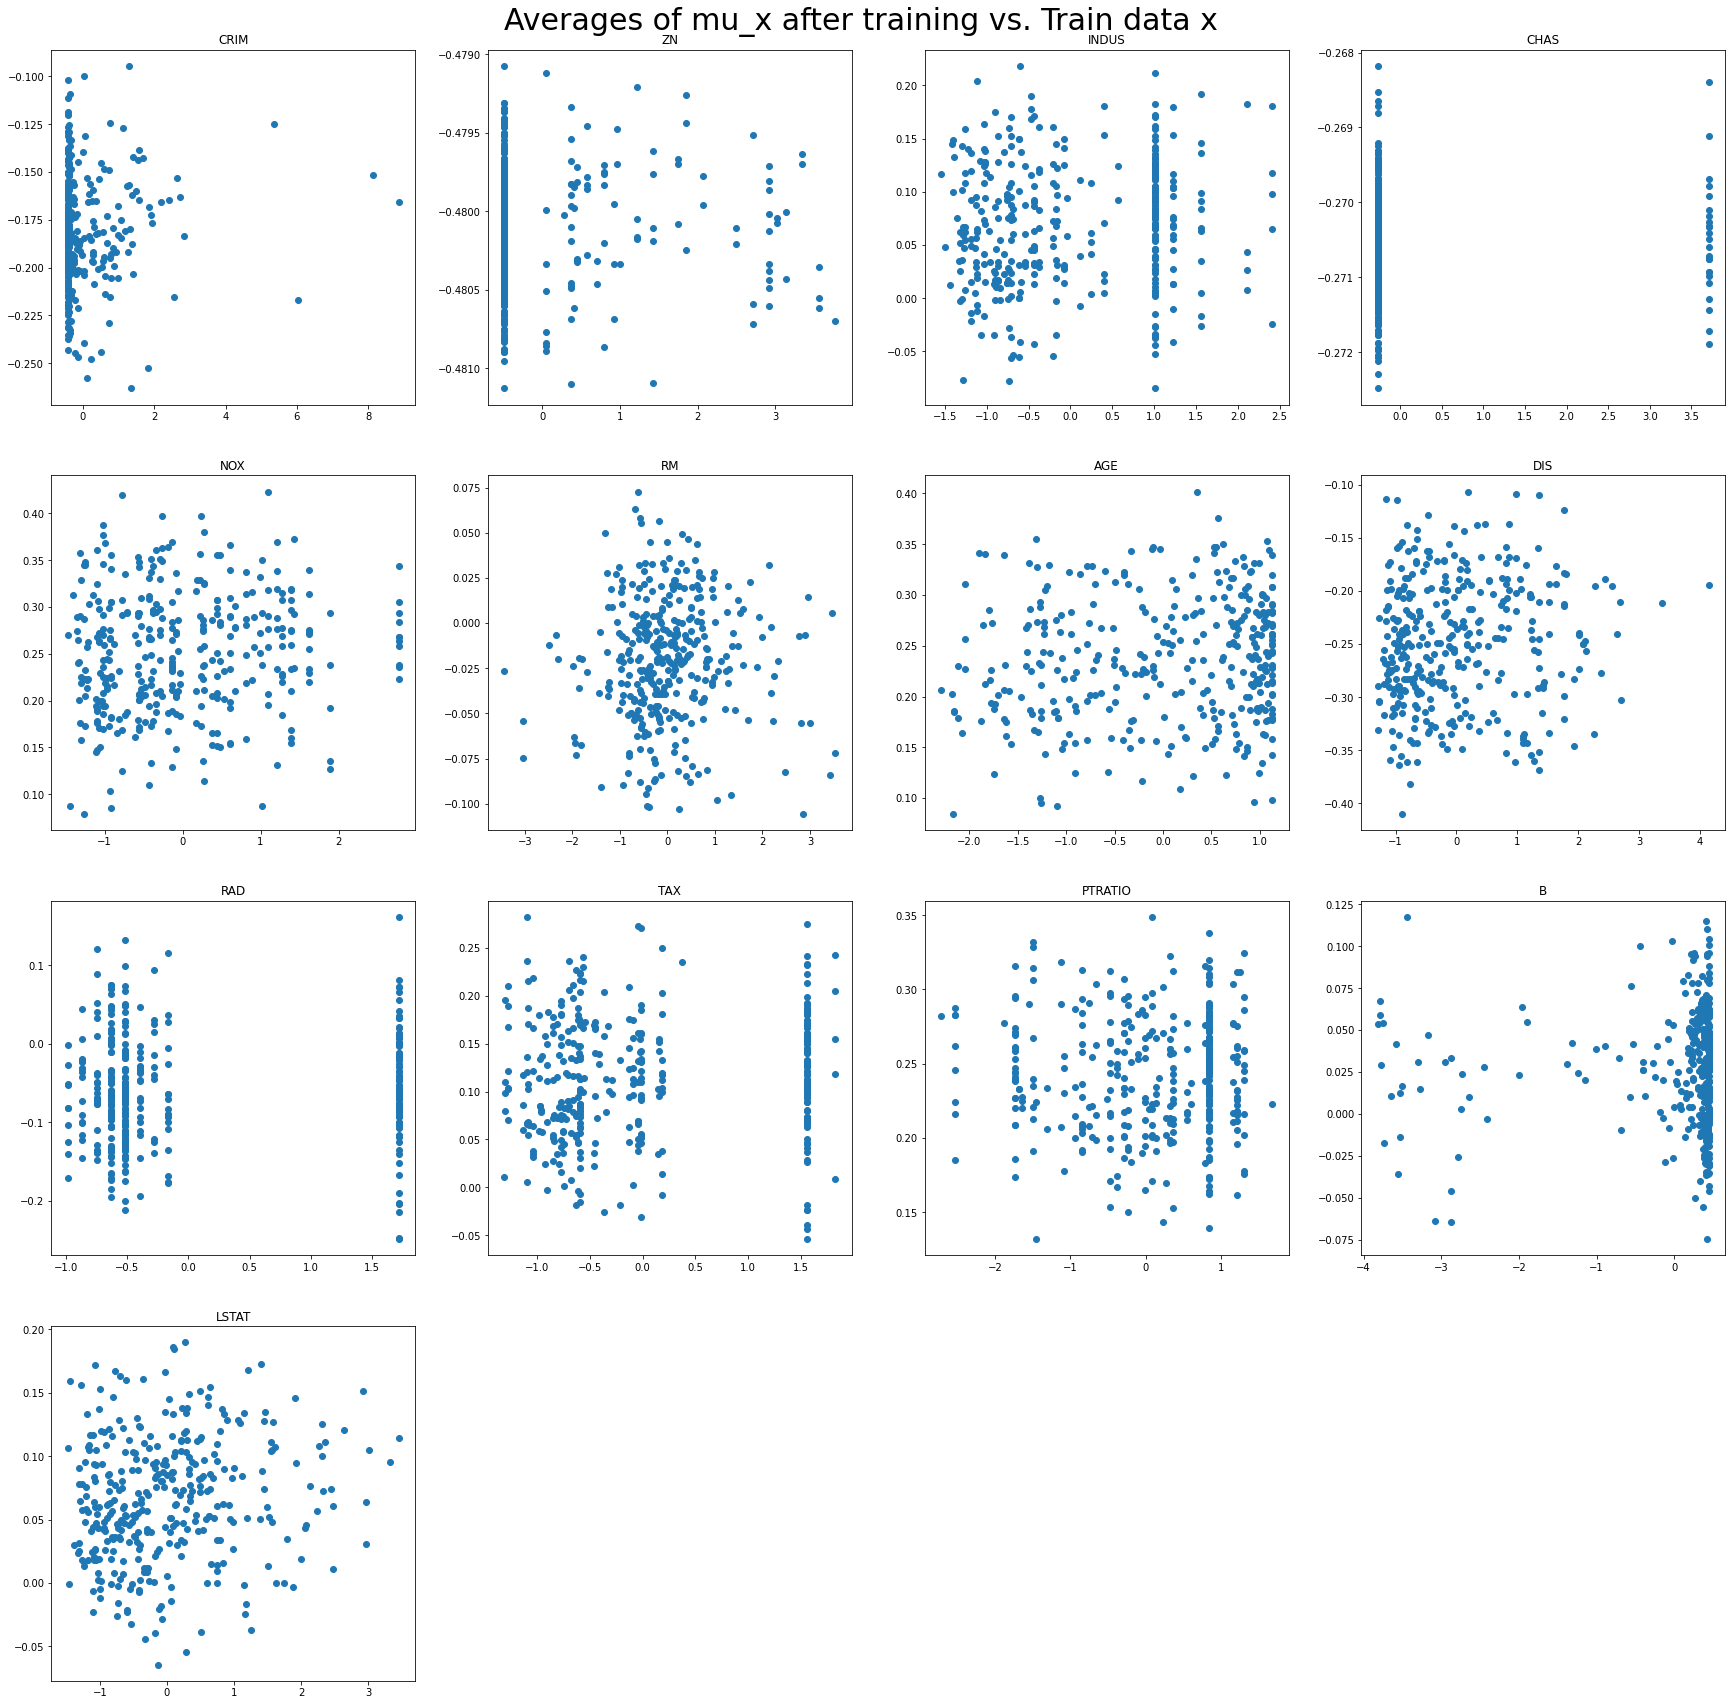

In [14]:
avg_mu_x = avg_mu_x.detach().numpy()
figs, axs = plt.subplots(4, 4, figsize=(30, 30))
count = 0 
for i in range(4):
    for j in range(4):
        if i*4+j >= 13: 
            break 
        axs[i, j].scatter(X_train[:,i*4+j], avg_mu_x[:,i*4+j])
        axs[i, j].set_title(raw_data.feature_names[i*4+j])
#         axs[i, j].set_ylabel("mu_x (average of 100 samples from model)")
#         axs[i, j].set_xlabel("x_in (train dataset)")
    if i*4+j >= 13: 
        break 

plt.suptitle("Averages of mu_x after training vs. Train data x", fontsize=30, y=0.9)
plt.delaxes(ax= axs[3,1]) 
plt.delaxes(ax= axs[3,2]) 
plt.delaxes(ax= axs[3,3]) 
        
plt.show()